## import libraries

In [1]:
import copy
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torch.optim import SGD

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

## load data

In [3]:
raw_data = "./data/raw/"

In [4]:
records_path = os.path.join(raw_data, './records.csv')
records = pd.read_csv(records_path)
records

,유저id,기분점수,긍부정,감정,이슈,시간,컨텐츠id
0,48038,1,EMOTION_NEGATIVE,우울한,삶의 의미,2023-06-04 07:21:23.493815+00,2250
1,48038,3,EMOTION_NEUTRAL,놀란,인간관계 속 피로,2023-06-29 03:44:31.453233+00,1521
2,48119,1,EMOTION_NEGATIVE,불안한,가족과의 갈등,2023-06-17 12:37:32.437419+00,1179
3,48119,2,EMOTION_NEGATIVE,스트레스,부부싸움,2023-06-18 03:39:15.31359+00,2284
4,48119,3,EMOTION_NEUTRAL,무기력한,생리,2023-06-29 09:48:19.89091+00,222
...,...,...,...,...,...,...,...
3290,63310,2,EMOTION_NEGATIVE,불안한,진로,2023-07-24 17:43:07.774945+00,1236
3291,63313,3,EMOTION_NEUTRAL,무기력한,자존감,2023-06-30 16:51:32.20724+00,160
3292,63313,3,EMOTION_NEGATIVE,불안한,반려동물,2023-06-30 16:53:21.994649+00,773
3293,63329,1,EMOTION_NEGATIVE,우울한,자존감,2023-06-30 17:28:15.905622+00,1284


In [5]:
contents_path = os.path.join(raw_data, './contents.csv')
contents = pd.read_csv(contents_path)
contents

,id,title
0,1706,1년뒤의 나에게 편지쓰기
1,2649,'고마워'를 수어로 표현하는 법 배워보기
2,2650,요즘 유행하는 노래를 휘파람으로 불어보기
3,2680,좋아하는 웹툰을 처음부터 다시 정주행하기
4,2659,가족과 함께 쇼핑 다녀오기
...,...,...
1243,2491,꼭 직접 가서 보고싶은 곳의 사진을 찾아 올리기
1244,2495,냉장고 속 음식들을 깔끔히 정리한 뒤 사진으로 남겨보기
1245,2496,반려동물이 웃긴 표정을 짓는 사진을 찍어보기
1246,2497,반려동물이 역동적으로 움직이는 사진을 찍어보기


## data information

records

기분 점수와 긍부정은 rank data

감정, 이슈, 컨텐츠는 categorical data

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295 entries, 0 to 3294
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   유저id    3295 non-null   int64 
 1   기분점수    3295 non-null   int64 
 2   긍부정     3295 non-null   object
 3   감정      3295 non-null   object
 4   이슈      3295 non-null   object
 5   시간      3295 non-null   object
 6   컨텐츠id   3295 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 180.3+ KB


In [8]:
records.loc[:, '유저id'].value_counts()

53407    63
48834    38
51134    35
52976    33
50069    31
         ..
58010     1
57938     1
57719     1
57638     1
63337     1
Name: 유저id, Length: 922, dtype: int64

count   3295.00
mean       2.81
std        1.25
min        1.00
25%        2.00
50%        3.00
75%        4.00
max        5.00
Name: 기분점수, dtype: float64


C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


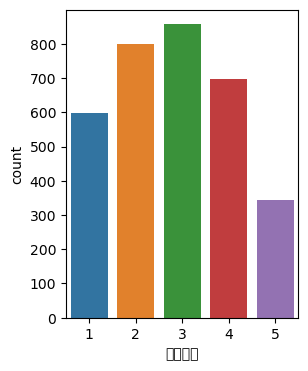

In [9]:
print(records.loc[:, '기분점수'].describe())

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
sns.countplot(x='기분점수', data=records.loc[:, ['기분점수']])
plt.show()

EMOTION_NEGATIVE    1617
EMOTION_POSITIVE     888
EMOTION_NEUTRAL      790
Name: 긍부정, dtype: int64


C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\disin\anaconda3\envs\torch_env1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


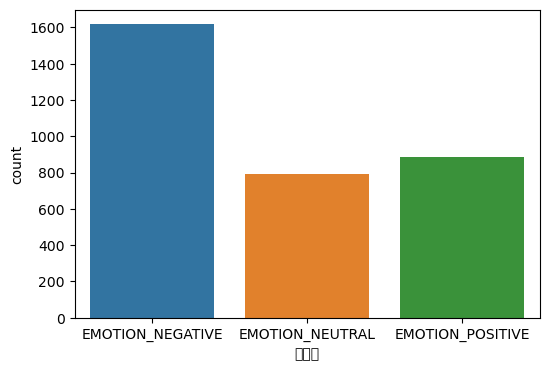

In [10]:
print(records.loc[:, '긍부정'].value_counts())

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x='긍부정', data=records.loc[:, ['긍부정']])
plt.show()

In [11]:
records.loc[:, '감정'].value_counts()

무기력한       251
복잡한        222
스트레스       222
불안한        204
별 감정 없는    179
          ... 
무감정          1
다가가고 싶은      1
어려움          1
몽글몽글         1
병신같은         1
Name: 감정, Length: 144, dtype: int64

In [12]:
records.loc[:, '이슈'].value_counts()

공부          565
이유 없음       454
가족          152
자존감         142
가족과의 갈등     118
           ... 
소비활동          1
누군가의 죽음       1
중독            1
행복하지 않음       1
버킷리스트 달성      1
Name: 이슈, Length: 274, dtype: int64

In [13]:
records.loc[:, '컨텐츠id'].value_counts()

1284    45
1292    26
2252    21
1725    21
2322    18
        ..
1913     1
369      1
1267     1
2112     1
1661     1
Name: 컨텐츠id, Length: 754, dtype: int64

contents

컨텐츠 정보에는 중복 항목 존재

In [14]:
contents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1248 non-null   int64 
 1   title   1248 non-null   object
dtypes: int64(1), object(1)
memory usage: 19.6+ KB


In [15]:
contents['id'].sort_values()

770     143
836     145
837     146
427     157
829     160
       ... 
286    2838
287    2839
280    2840
279    2841
288    2842
Name: id, Length: 1248, dtype: int64

In [16]:
contents.loc[:, 'title'].value_counts()

1년뒤의 나에게 편지쓰기                   2
오늘의 달을 찍어보기                     2
아이를 믿고 맡길 수 있는 사람들의 목록을 적어보기    2
애인의 이름으로 N행시 지어보기               2
30초 안에 지금 나에게 가장 중요한 3가지 써보기    2
                               ..
귀여운 스티커 방 군데군데 붙이기              1
5분 타이머 맞춰놓고 하고싶은 말 허공에 쏟아내기     1
손가락으로 펜 돌리는 법 배워보기              1
가족에게 가장 고마웠던 순간이 언제였는지 떠올려보기    1
증명사진을 찍듯 반려동물의 얼굴을 찍어보기         1
Name: title, Length: 1203, dtype: int64

In [17]:
contents_count = contents.loc[:, 'title'].value_counts()
contents.loc[contents['title'] == contents_count.loc[contents_count > 1].index[0]]

,id,title
0,1706,1년뒤의 나에게 편지쓰기
57,2761,1년뒤의 나에게 편지쓰기


In [18]:
# pd.set_option('display.max_rows', None)
# display(contents[~contents.duplicated(subset=['title'], keep='first')].sort_values(by=['컨텐츠id', 'title']).reset_index(drop=True))
# pd.reset_option('max_rows')

## edit the dataframes

change the column of the contents df to merge 2 dfs

In [19]:
print(records.columns)
print(contents.columns)

Index(['유저id', '기분점수', '긍부정', '감정', '이슈', '시간', '컨텐츠id'], dtype='object')
Index(['id', 'title'], dtype='object')


In [20]:
contents.rename(columns={'id':'컨텐츠id'}, inplace=True)
contents.columns

Index(['컨텐츠id', 'title'], dtype='object')

merge 2 dfs

In [21]:
df_0 = records.merge(contents, how='inner').sort_values(['유저id', '시간']).reset_index(drop=True)
df_0

,유저id,기분점수,긍부정,감정,이슈,시간,컨텐츠id,title
0,48038,3,EMOTION_NEUTRAL,우울한,불면,2023-06-01 04:34:47.251485+00,1499,최근 3일간 각각 몇 시간씩 잤는지 기억해 적어보기
1,48038,2,EMOTION_NEGATIVE,스트레스,타인과의 갈등,2023-06-04 07:20:14.553061+00,1275,몸을 동그랗게 말아서 무릎을 꼭 끌어안고 30초간 있기
2,48038,1,EMOTION_NEGATIVE,우울한,삶의 의미,2023-06-04 07:21:23.493815+00,2250,올해 꼭 이루고 싶은 한 가지를 적어보기
3,48038,3,EMOTION_NEGATIVE,피곤한,운동,2023-06-04 07:22:36.923682+00,1695,오늘 일정에 짧은 운동 세션을 계획해 넣기
4,48038,4,EMOTION_POSITIVE,행복한,운동,2023-06-05 09:46:00.308003+00,162,거울 속의 나에게 엄지척 해주기
...,...,...,...,...,...,...,...,...
3290,63313,3,EMOTION_NEUTRAL,무기력한,자존감,2023-06-30 16:51:32.20724+00,160,거울 속의 나와 하이파이브 하기
3291,63313,3,EMOTION_NEGATIVE,불안한,반려동물,2023-06-30 16:53:21.994649+00,773,눈을 감고 자연의 소리를 담은 ASMR을 들어보기
3292,63329,1,EMOTION_NEGATIVE,우울한,자존감,2023-06-30 17:28:15.905622+00,1284,인형이나 이불을 꼭 끌어안아보기
3293,63337,2,EMOTION_NEGATIVE,불안한,공부,2023-06-30 17:51:54.872594+00,945,감명깊었던 명언을 적어 신발장 앞에 붙여두기


make dataframes of duplicated contents

In [22]:
duplicated_contents_bool = contents.duplicated(subset=['title'], keep=False)
duplicated_contents_bool.value_counts()

False    1158
True       90
dtype: int64

In [23]:
duplicated_contents_id = contents[duplicated_contents_bool].sort_values(by=['title', '컨텐츠id']).reset_index(drop=True)
duplicated_contents_id

,컨텐츠id,title
0,1706,1년뒤의 나에게 편지쓰기
1,2761,1년뒤의 나에게 편지쓰기
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기
4,1300,가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기
...,...,...
85,1487,처음 일을 시작했을 때의 나에게 하고 싶은 조언 적어보기
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


In [24]:
duplicated_contents_uniq = duplicated_contents_id.drop_duplicates(subset='title').drop(labels='컨텐츠id', axis=1).reset_index(drop=True).squeeze().tolist()
duplicated_contents_uniq

['1년뒤의 나에게 편지쓰기',
 '30초 안에 지금 나에게 가장 중요한 3가지 써보기',
 '가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기',
 '가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기',
 '가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기',
 '가족에게 하고싶은 말 적어보기',
 '경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기',
 '군생활을 활용해 이룰 수 있는 목표 한 가지 설정해보기',
 '그 동안 고생한 나에게 편지 써보기',
 '나를 불안하게 하는 것이 정확히 무엇인지 적어보기',
 '나만의 버킷리스트 5가지 적어보기',
 '나에게 편안함을 주는 물건 5가지 적어보기',
 '내 이름으로 N행시 지어보기',
 '내 책상 위 가장 마음에 드는 물건을 찍어보기',
 '내 책상 위의 물건 중 가장 아끼는 물건 찍어보기',
 '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기',
 '내가 일하는 방식에 대한 소개글 적어보기',
 '내가 하고자 하는 일의 이유를 3가지 적어보기',
 '내일 기대되는 일 한 가지 적어보기',
 '내일의 일정표 꼼꼼하게 적어보기',
 '노을 지는 모습을 사진으로 찍어보기',
 '떠나보낸 사람에게 편지 써보기',
 '맘에 드는 스티커 하나를 이마에 붙이고 셀카 찍어보기',
 '무지개다리를 건넌 반려동물에게 하고 싶은 말 적어보기',
 '밖에 나가서 보이는 첫번째 꽃을 찍어보기',
 '버거워질 때 흔쾌히 나를 도우러 와줄 사람들의 목록을 적어보기',
 '아이를 믿고 맡길 수 있는 사람들의 목록을 적어보기',
 '애인의 이름으로 N행시 지어보기',
 '애인의 좋은 점과 개선했으면 하는 점 하나씩만 적어보기',
 '어린 시절의 기억에 대한 세 줄짜리 시 써보기',
 '어제 가장 좋았던 일 3가지 적어보기',
 '오늘 감사한 일 3가지 적어보기',
 '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기',
 '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기',
 '오늘의 달

fix df_0 w.r.t duplicated_contents_id

In [25]:
df = copy.deepcopy(df_0)

for i in range(len(df_0)):
    if df_0.iloc[i].title in duplicated_contents_uniq:
        
        print(f"== fix the id of '{df_0.iloc[i].title}' of the index {i} ==")
        
        temp = duplicated_contents_id.loc[duplicated_contents_id['title']==df_0.iloc[i].title]
        display(temp)
        
        if df_0.iloc[i].컨텐츠id != temp.loc[:, '컨텐츠id'].iloc[0]:
            pre_value = df.iloc[i].컨텐츠id            
            df.iloc[i] = df.iloc[i].replace(pre_value, temp.loc[:, '컨텐츠id'].iloc[0])
            print(f"index: {i}    id: {pre_value} => {df.iloc[i].컨텐츠id} \n")
            pre_value = np.NAN
        else:
            print(f"index: {i}    no change \n")


== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 8 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 8    id: 1453 => 787 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 9 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 9    id: 1451 => 157 

== fix the id of '어제 가장 좋았던 일 3가지 적어보기' of the index 46 ==


,컨텐츠id,title
60,432,어제 가장 좋았던 일 3가지 적어보기
61,1492,어제 가장 좋았던 일 3가지 적어보기


index: 46    id: 1492 => 432 

== fix the id of '휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기' of the index 48 ==


,컨텐츠id,title
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기
89,2417,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


index: 48    no change 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 94 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 94    id: 1464 => 290 

== fix the id of '가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기' of the index 105 ==


,컨텐츠id,title
6,1299,가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기
7,2610,가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기


index: 105    no change 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 129 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 129    id: 1461 => 816 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 153 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 153    id: 1452 => 786 

== fix the id of '가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기' of the index 154 ==


,컨텐츠id,title
8,1301,가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기
9,2612,가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기


index: 154    no change 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 156 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 156    id: 1477 => 829 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 158 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 158    id: 1453 => 787 

== fix the id of '내 책상 위 가장 마음에 드는 물건을 찍어보기' of the index 186 ==


,컨텐츠id,title
26,368,내 책상 위 가장 마음에 드는 물건을 찍어보기
27,2414,내 책상 위 가장 마음에 드는 물건을 찍어보기


index: 186    no change 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 187 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 187    id: 1464 => 290 

== fix the id of '1년뒤의 나에게 편지쓰기' of the index 212 ==


,컨텐츠id,title
0,1706,1년뒤의 나에게 편지쓰기
1,2761,1년뒤의 나에게 편지쓰기


index: 212    no change 

== fix the id of '자기 전 내일 먹고싶은 음식 적어보기' of the index 225 ==


,컨텐츠id,title
76,356,자기 전 내일 먹고싶은 음식 적어보기
77,1481,자기 전 내일 먹고싶은 음식 적어보기


index: 225    id: 1481 => 356 

== fix the id of '어제 가장 좋았던 일 3가지 적어보기' of the index 227 ==


,컨텐츠id,title
60,432,어제 가장 좋았던 일 3가지 적어보기
61,1492,어제 가장 좋았던 일 3가지 적어보기


index: 227    id: 1492 => 432 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 240 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 240    id: 1452 => 786 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 245 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 245    id: 1453 => 787 

== fix the id of '가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기' of the index 250 ==


,컨텐츠id,title
8,1301,가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기
9,2612,가장 최근에 읽은 책의 내용을 이모티콘 10개로 표현해보기


index: 250    no change 

== fix the id of '가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기' of the index 263 ==


,컨텐츠id,title
6,1299,가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기
7,2610,가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기


index: 263    no change 

== fix the id of '내가 하고자 하는 일의 이유를 3가지 적어보기' of the index 289 ==


,컨텐츠id,title
34,398,내가 하고자 하는 일의 이유를 3가지 적어보기
35,1551,내가 하고자 하는 일의 이유를 3가지 적어보기


index: 289    id: 1551 => 398 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 330 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 330    id: 1493 => 899 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 335 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 335    id: 1478 => 832 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 340 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 340    id: 1459 => 813 

== fix the id of '나를 불안하게 하는 것이 정확히 무엇인지 적어보기' of the index 351 ==


,컨텐츠id,title
18,328,나를 불안하게 하는 것이 정확히 무엇인지 적어보기
19,1476,나를 불안하게 하는 것이 정확히 무엇인지 적어보기


index: 351    id: 1476 => 328 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 362 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 362    id: 1478 => 832 

== fix the id of '가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기' of the index 368 ==


,컨텐츠id,title
4,1300,가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기
5,2611,가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기


index: 368    no change 

== fix the id of '내 책상 위 가장 마음에 드는 물건을 찍어보기' of the index 431 ==


,컨텐츠id,title
26,368,내 책상 위 가장 마음에 드는 물건을 찍어보기
27,2414,내 책상 위 가장 마음에 드는 물건을 찍어보기


index: 431    no change 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 437 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 437    id: 1459 => 813 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 453 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 453    id: 1451 => 157 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 464 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 464    id: 1451 => 157 

== fix the id of '경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기' of the index 502 ==


,컨텐츠id,title
12,313,경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기
13,1473,경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기


index: 502    id: 1473 => 313 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 511 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 511    id: 1451 => 157 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 533 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 533    id: 1477 => 829 

== fix the id of '자기 전 내일 먹고싶은 음식 적어보기' of the index 534 ==


,컨텐츠id,title
76,356,자기 전 내일 먹고싶은 음식 적어보기
77,1481,자기 전 내일 먹고싶은 음식 적어보기


index: 534    id: 1481 => 356 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 552 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 552    id: 1453 => 787 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 559 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 559    id: 1451 => 157 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 584 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 584    id: 1464 => 290 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 592 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 592    id: 1477 => 829 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 598 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 598    id: 1464 => 290 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 653 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 653    id: 1459 => 813 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 690 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 690    id: 1461 => 816 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 699 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 699    id: 1464 => 290 

== fix the id of '내일의 일정표 꼼꼼하게 적어보기' of the index 715 ==


,컨텐츠id,title
38,757,내일의 일정표 꼼꼼하게 적어보기
39,1450,내일의 일정표 꼼꼼하게 적어보기


index: 715    id: 1450 => 757 

== fix the id of '이제 막 일을 시작하던 시기의 과거의 나에게 편지 써보기' of the index 745 ==


,컨텐츠id,title
74,277,이제 막 일을 시작하던 시기의 과거의 나에게 편지 써보기
75,1460,이제 막 일을 시작하던 시기의 과거의 나에게 편지 써보기


index: 745    id: 1460 => 277 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 751 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 751    id: 1478 => 832 

== fix the id of '가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기' of the index 761 ==


,컨텐츠id,title
6,1299,가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기
7,2610,가장 최근에 본 영화의 줄거리를 이모티콘 10개로 표현해보기


index: 761    no change 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 768 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 768    id: 1451 => 157 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 802 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 802    id: 1459 => 813 

== fix the id of '가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기' of the index 805 ==


,컨텐츠id,title
4,1300,가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기
5,2611,가장 최근에 본 공연의 내용을 이모티콘 10개로 표현해보기


index: 805    no change 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 825 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 825    id: 1493 => 899 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 837 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 837    id: 1461 => 816 

== fix the id of '휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기' of the index 838 ==


,컨텐츠id,title
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기
89,2417,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


index: 838    no change 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 839 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 839    id: 1493 => 899 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 844 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 844    id: 1493 => 899 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 851 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 851    id: 1493 => 899 

== fix the id of '내가 하고자 하는 일의 이유를 3가지 적어보기' of the index 852 ==


,컨텐츠id,title
34,398,내가 하고자 하는 일의 이유를 3가지 적어보기
35,1551,내가 하고자 하는 일의 이유를 3가지 적어보기


index: 852    id: 1551 => 398 

== fix the id of '1년뒤의 나에게 편지쓰기' of the index 881 ==


,컨텐츠id,title
0,1706,1년뒤의 나에게 편지쓰기
1,2761,1년뒤의 나에게 편지쓰기


index: 881    no change 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 923 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 923    id: 1451 => 157 

== fix the id of '지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기' of the index 926 ==


,컨텐츠id,title
78,292,지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기
79,1466,지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기


index: 926    id: 1466 => 292 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 954 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 954    id: 1451 => 157 

== fix the id of '애인의 이름으로 N행시 지어보기' of the index 957 ==


,컨텐츠id,title
54,297,애인의 이름으로 N행시 지어보기
55,1467,애인의 이름으로 N행시 지어보기


index: 957    id: 1467 => 297 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 1057 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 1057    id: 1461 => 816 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 1064 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 1064    id: 1477 => 829 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 1119 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 1119    id: 1497 => 930 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 1153 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 1153    id: 1478 => 832 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 1166 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 1166    id: 1453 => 787 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 1184 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 1184    id: 1453 => 787 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 1195 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 1195    id: 1459 => 813 

== fix the id of '나에게 편안함을 주는 물건 5가지 적어보기' of the index 1217 ==


,컨텐츠id,title
22,430,나에게 편안함을 주는 물건 5가지 적어보기
23,1491,나에게 편안함을 주는 물건 5가지 적어보기


index: 1217    id: 1491 => 430 

== fix the id of '휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기' of the index 1297 ==


,컨텐츠id,title
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기
89,2417,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


index: 1297    no change 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 1299 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 1299    id: 1477 => 829 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 1344 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 1344    id: 1497 => 930 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 1354 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 1354    id: 1451 => 157 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 1358 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 1358    id: 1459 => 813 

== fix the id of '애인의 이름으로 N행시 지어보기' of the index 1360 ==


,컨텐츠id,title
54,297,애인의 이름으로 N행시 지어보기
55,1467,애인의 이름으로 N행시 지어보기


index: 1360    id: 1467 => 297 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 1367 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 1367    id: 1459 => 813 

== fix the id of '나에게 편안함을 주는 물건 5가지 적어보기' of the index 1387 ==


,컨텐츠id,title
22,430,나에게 편안함을 주는 물건 5가지 적어보기
23,1491,나에게 편안함을 주는 물건 5가지 적어보기


index: 1387    id: 1491 => 430 

== fix the id of '처음 일을 시작했을 때의 나에게 하고 싶은 조언 적어보기' of the index 1427 ==


,컨텐츠id,title
84,425,처음 일을 시작했을 때의 나에게 하고 싶은 조언 적어보기
85,1487,처음 일을 시작했을 때의 나에게 하고 싶은 조언 적어보기


index: 1427    id: 1487 => 425 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 1433 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 1433    id: 1464 => 290 

== fix the id of '밖에 나가서 보이는 첫번째 꽃을 찍어보기' of the index 1449 ==


,컨텐츠id,title
48,359,밖에 나가서 보이는 첫번째 꽃을 찍어보기
49,2413,밖에 나가서 보이는 첫번째 꽃을 찍어보기


index: 1449    no change 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 1465 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 1465    id: 1477 => 829 

== fix the id of '가족에게 하고싶은 말 적어보기' of the index 1470 ==


,컨텐츠id,title
10,256,가족에게 하고싶은 말 적어보기
11,1455,가족에게 하고싶은 말 적어보기


index: 1470    id: 1455 => 256 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 1489 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 1489    id: 1451 => 157 

== fix the id of '내가 하고자 하는 일의 이유를 3가지 적어보기' of the index 1495 ==


,컨텐츠id,title
34,398,내가 하고자 하는 일의 이유를 3가지 적어보기
35,1551,내가 하고자 하는 일의 이유를 3가지 적어보기


index: 1495    id: 1551 => 398 

== fix the id of '오늘 감사한 일 3가지 적어보기' of the index 1496 ==


,컨텐츠id,title
62,157,오늘 감사한 일 3가지 적어보기
63,1451,오늘 감사한 일 3가지 적어보기


index: 1496    id: 1451 => 157 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 1498 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 1498    id: 1453 => 787 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 1546 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 1546    id: 1464 => 290 

== fix the id of '가족에게 하고싶은 말 적어보기' of the index 1572 ==


,컨텐츠id,title
10,256,가족에게 하고싶은 말 적어보기
11,1455,가족에게 하고싶은 말 적어보기


index: 1572    id: 1455 => 256 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 1575 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 1575    id: 1453 => 787 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 1586 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 1586    id: 1452 => 786 

== fix the id of '노을 지는 모습을 사진으로 찍어보기' of the index 1601 ==


,컨텐츠id,title
40,419,노을 지는 모습을 사진으로 찍어보기
41,2415,노을 지는 모습을 사진으로 찍어보기


index: 1601    no change 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 1608 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 1608    id: 1477 => 829 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 1610 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 1610    id: 1478 => 832 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 1614 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 1614    id: 1461 => 816 

== fix the id of '내일의 일정표 꼼꼼하게 적어보기' of the index 1644 ==


,컨텐츠id,title
38,757,내일의 일정표 꼼꼼하게 적어보기
39,1450,내일의 일정표 꼼꼼하게 적어보기


index: 1644    id: 1450 => 757 

== fix the id of '내일의 일정표 꼼꼼하게 적어보기' of the index 1667 ==


,컨텐츠id,title
38,757,내일의 일정표 꼼꼼하게 적어보기
39,1450,내일의 일정표 꼼꼼하게 적어보기


index: 1667    id: 1450 => 757 

== fix the id of '어제 가장 좋았던 일 3가지 적어보기' of the index 1733 ==


,컨텐츠id,title
60,432,어제 가장 좋았던 일 3가지 적어보기
61,1492,어제 가장 좋았던 일 3가지 적어보기


index: 1733    id: 1492 => 432 

== fix the id of '지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기' of the index 1791 ==


,컨텐츠id,title
78,292,지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기
79,1466,지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기


index: 1791    id: 1466 => 292 

== fix the id of '경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기' of the index 1823 ==


,컨텐츠id,title
12,313,경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기
13,1473,경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기


index: 1823    id: 1473 => 313 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 1837 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 1837    id: 1452 => 786 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 1874 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 1874    id: 1464 => 290 

== fix the id of '내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기' of the index 1887 ==


,컨텐츠id,title
30,290,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기
31,1464,내가 바라는 1년 뒤 내 모습에 대해 일기를 써보기


index: 1887    id: 1464 => 290 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 1897 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 1897    id: 1461 => 816 

== fix the id of '내가 하고자 하는 일의 이유를 3가지 적어보기' of the index 1947 ==


,컨텐츠id,title
34,398,내가 하고자 하는 일의 이유를 3가지 적어보기
35,1551,내가 하고자 하는 일의 이유를 3가지 적어보기


index: 1947    id: 1551 => 398 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 1990 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 1990    id: 1478 => 832 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 2007 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 2007    id: 1461 => 816 

== fix the id of '나를 불안하게 하는 것이 정확히 무엇인지 적어보기' of the index 2040 ==


,컨텐츠id,title
18,328,나를 불안하게 하는 것이 정확히 무엇인지 적어보기
19,1476,나를 불안하게 하는 것이 정확히 무엇인지 적어보기


index: 2040    id: 1476 => 328 

== fix the id of '경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기' of the index 2060 ==


,컨텐츠id,title
12,313,경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기
13,1473,경험하게 될 혹은 경험하고 있는 큰 변화들을 5가지 나열해보기


index: 2060    id: 1473 => 313 

== fix the id of '애인의 좋은 점과 개선했으면 하는 점 하나씩만 적어보기' of the index 2070 ==


,컨텐츠id,title
56,291,애인의 좋은 점과 개선했으면 하는 점 하나씩만 적어보기
57,1465,애인의 좋은 점과 개선했으면 하는 점 하나씩만 적어보기


index: 2070    id: 1465 => 291 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 2079 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 2079    id: 1461 => 816 

== fix the id of '내 책상 위 가장 마음에 드는 물건을 찍어보기' of the index 2086 ==


,컨텐츠id,title
26,368,내 책상 위 가장 마음에 드는 물건을 찍어보기
27,2414,내 책상 위 가장 마음에 드는 물건을 찍어보기


index: 2086    no change 

== fix the id of '밖에 나가서 보이는 첫번째 꽃을 찍어보기' of the index 2180 ==


,컨텐츠id,title
48,359,밖에 나가서 보이는 첫번째 꽃을 찍어보기
49,2413,밖에 나가서 보이는 첫번째 꽃을 찍어보기


index: 2180    no change 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2195 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2195    id: 1493 => 899 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 2204 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 2204    id: 1497 => 930 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 2206 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 2206    id: 1452 => 786 

== fix the id of '나에게 편안함을 주는 물건 5가지 적어보기' of the index 2226 ==


,컨텐츠id,title
22,430,나에게 편안함을 주는 물건 5가지 적어보기
23,1491,나에게 편안함을 주는 물건 5가지 적어보기


index: 2226    id: 1491 => 430 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2250 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2250    id: 1493 => 899 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 2296 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 2296    id: 1497 => 930 

== fix the id of '자기 전 내일 먹고싶은 음식 적어보기' of the index 2336 ==


,컨텐츠id,title
76,356,자기 전 내일 먹고싶은 음식 적어보기
77,1481,자기 전 내일 먹고싶은 음식 적어보기


index: 2336    id: 1481 => 356 

== fix the id of '그 동안 고생한 나에게 편지 써보기' of the index 2368 ==


,컨텐츠id,title
16,813,그 동안 고생한 나에게 편지 써보기
17,1459,그 동안 고생한 나에게 편지 써보기


index: 2368    id: 1459 => 813 

== fix the id of '휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기' of the index 2416 ==


,컨텐츠id,title
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기
89,2417,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


index: 2416    no change 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 2465 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 2465    id: 1461 => 816 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2476 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2476    id: 1493 => 899 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 2496 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 2496    id: 1497 => 930 

== fix the id of '자기 전 내일 먹고싶은 음식 적어보기' of the index 2508 ==


,컨텐츠id,title
76,356,자기 전 내일 먹고싶은 음식 적어보기
77,1481,자기 전 내일 먹고싶은 음식 적어보기


index: 2508    id: 1481 => 356 

== fix the id of '지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기' of the index 2556 ==


,컨텐츠id,title
78,292,지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기
79,1466,지금의 관계 속에서 내 모습이 어떻게 변해왔는지 적어보기


index: 2556    id: 1466 => 292 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 2572 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 2572    id: 1497 => 930 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2619 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2619    id: 1493 => 899 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 2661 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 2661    id: 1497 => 930 

== fix the id of '지난 주에 있었던 가장 감사한 일 한 가지 적어보기' of the index 2676 ==


,컨텐츠id,title
80,429,지난 주에 있었던 가장 감사한 일 한 가지 적어보기
81,1490,지난 주에 있었던 가장 감사한 일 한 가지 적어보기


index: 2676    id: 1490 => 429 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 2686 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 2686    id: 1497 => 930 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2708 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2708    id: 1493 => 899 

== fix the id of '휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기' of the index 2721 ==


,컨텐츠id,title
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기
89,2417,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


index: 2721    no change 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 2725 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 2725    id: 1461 => 816 

== fix the id of '휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기' of the index 2733 ==


,컨텐츠id,title
88,861,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기
89,2417,휴대폰 사진첩에서 1년 전 오늘 찍은 사진 찾아보기


index: 2733    no change 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 2742 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 2742    id: 1452 => 786 

== fix the id of '나에게 편안함을 주는 물건 5가지 적어보기' of the index 2743 ==


,컨텐츠id,title
22,430,나에게 편안함을 주는 물건 5가지 적어보기
23,1491,나에게 편안함을 주는 물건 5가지 적어보기


index: 2743    id: 1491 => 430 

== fix the id of '이 경험을 통해 스스로에 대해 배운 점 3가지 적어보기' of the index 2780 ==


,컨텐츠id,title
70,819,이 경험을 통해 스스로에 대해 배운 점 3가지 적어보기
71,1471,이 경험을 통해 스스로에 대해 배운 점 3가지 적어보기


index: 2780    id: 1471 => 819 

== fix the id of '내일의 일정표 꼼꼼하게 적어보기' of the index 2798 ==


,컨텐츠id,title
38,757,내일의 일정표 꼼꼼하게 적어보기
39,1450,내일의 일정표 꼼꼼하게 적어보기


index: 2798    id: 1450 => 757 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2810 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2810    id: 1493 => 899 

== fix the id of '나만의 버킷리스트 5가지 적어보기' of the index 2844 ==


,컨텐츠id,title
20,816,나만의 버킷리스트 5가지 적어보기
21,1461,나만의 버킷리스트 5가지 적어보기


index: 2844    id: 1461 => 816 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 2855 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 2855    id: 1493 => 899 

== fix the id of '지난 주에 있었던 가장 감사한 일 한 가지 적어보기' of the index 2867 ==


,컨텐츠id,title
80,429,지난 주에 있었던 가장 감사한 일 한 가지 적어보기
81,1490,지난 주에 있었던 가장 감사한 일 한 가지 적어보기


index: 2867    id: 1490 => 429 

== fix the id of '한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기' of the index 2886 ==


,컨텐츠id,title
86,829,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기
87,1477,한달 목표와 1년 목표를 각각 구체적으로 2가지씩 적어보기


index: 2886    id: 1477 => 829 

== fix the id of '어제 가장 좋았던 일 3가지 적어보기' of the index 2963 ==


,컨텐츠id,title
60,432,어제 가장 좋았던 일 3가지 적어보기
61,1492,어제 가장 좋았던 일 3가지 적어보기


index: 2963    id: 1492 => 432 

== fix the id of '밖에 나가서 보이는 첫번째 꽃을 찍어보기' of the index 2978 ==


,컨텐츠id,title
48,359,밖에 나가서 보이는 첫번째 꽃을 찍어보기
49,2413,밖에 나가서 보이는 첫번째 꽃을 찍어보기


index: 2978    no change 

== fix the id of '나에게 편안함을 주는 물건 5가지 적어보기' of the index 3182 ==


,컨텐츠id,title
22,430,나에게 편안함을 주는 물건 5가지 적어보기
23,1491,나에게 편안함을 주는 물건 5가지 적어보기


index: 3182    id: 1491 => 430 

== fix the id of '30초 안에 지금 나에게 가장 중요한 3가지 써보기' of the index 3200 ==


,컨텐츠id,title
2,899,30초 안에 지금 나에게 가장 중요한 3가지 써보기
3,1493,30초 안에 지금 나에게 가장 중요한 3가지 써보기


index: 3200    id: 1493 => 899 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 3224 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 3224    id: 1478 => 832 

== fix the id of '어린 시절의 기억에 대한 세 줄짜리 시 써보기' of the index 3233 ==


,컨텐츠id,title
58,787,어린 시절의 기억에 대한 세 줄짜리 시 써보기
59,1453,어린 시절의 기억에 대한 세 줄짜리 시 써보기


index: 3233    id: 1453 => 787 

== fix the id of '오늘 있었던 일에 대한 두 문장짜리 일기 쓰기' of the index 3239 ==


,컨텐츠id,title
64,786,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기
65,1452,오늘 있었던 일에 대한 두 문장짜리 일기 쓰기


index: 3239    id: 1452 => 786 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 3276 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 3276    id: 1497 => 930 

== fix the id of '내일 기대되는 일 한 가지 적어보기' of the index 3287 ==


,컨텐츠id,title
36,930,내일 기대되는 일 한 가지 적어보기
37,1497,내일 기대되는 일 한 가지 적어보기


index: 3287    id: 1497 => 930 

== fix the id of '오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기' of the index 3294 ==


,컨텐츠id,title
66,832,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기
67,1478,오늘 하루를 위한 작고 구체적인 목표 3가지 세워보기


index: 3294    id: 1478 => 832 



check the above cell

In [26]:
deleted_contents_ids = duplicated_contents_id.drop_duplicates(subset='title', keep='last').drop(labels='title', axis=1).reset_index(drop=True).squeeze().tolist()

cnt = 0
for i in range(len(df)):
    if df.iloc[i].title in duplicated_contents_uniq:
        cnt += 1
        print(f"count: {cnt}, index: {i}, content id: {df.iloc[i].컨텐츠id}")
        if df.iloc[i].컨텐츠id in deleted_contents_ids:
            print(f"remain duplicated id {df.iloc[i].컨텐츠id} in the index {i}")
        else:
            print("... ok!")

count: 1, index: 8, content id: 787
... ok!
count: 2, index: 9, content id: 157
... ok!
count: 3, index: 46, content id: 432
... ok!
count: 4, index: 48, content id: 861
... ok!
count: 5, index: 94, content id: 290
... ok!
count: 6, index: 105, content id: 1299
... ok!
count: 7, index: 129, content id: 816
... ok!
count: 8, index: 153, content id: 786
... ok!
count: 9, index: 154, content id: 1301
... ok!
count: 10, index: 156, content id: 829
... ok!
count: 11, index: 158, content id: 787
... ok!
count: 12, index: 186, content id: 368
... ok!
count: 13, index: 187, content id: 290
... ok!
count: 14, index: 212, content id: 1706
... ok!
count: 15, index: 225, content id: 356
... ok!
count: 16, index: 227, content id: 432
... ok!
count: 17, index: 240, content id: 786
... ok!
count: 18, index: 245, content id: 787
... ok!
count: 19, index: 250, content id: 1301
... ok!
count: 20, index: 263, content id: 1299
... ok!
count: 21, index: 289, content id: 398
... ok!
count: 22, index: 330, c

divide label and input

In [27]:
df_label = df[['유저id', '시간', '컨텐츠id', 'title']]
df_input0 = df.drop(labels=['컨텐츠id', 'title'], axis=1)

factorize categorical and ranking features

In [28]:
df_input0[['긍부정', '감정', '이슈']] = df_input0[['긍부정', '감정', '이슈']].apply(lambda x: pd.factorize(x)[0] + 1)

In [29]:
display(df_label)
display(df_input0)

,유저id,시간,컨텐츠id,title
0,48038,2023-06-01 04:34:47.251485+00,1499,최근 3일간 각각 몇 시간씩 잤는지 기억해 적어보기
1,48038,2023-06-04 07:20:14.553061+00,1275,몸을 동그랗게 말아서 무릎을 꼭 끌어안고 30초간 있기
2,48038,2023-06-04 07:21:23.493815+00,2250,올해 꼭 이루고 싶은 한 가지를 적어보기
3,48038,2023-06-04 07:22:36.923682+00,1695,오늘 일정에 짧은 운동 세션을 계획해 넣기
4,48038,2023-06-05 09:46:00.308003+00,162,거울 속의 나에게 엄지척 해주기
...,...,...,...,...
3290,63313,2023-06-30 16:51:32.20724+00,160,거울 속의 나와 하이파이브 하기
3291,63313,2023-06-30 16:53:21.994649+00,773,눈을 감고 자연의 소리를 담은 ASMR을 들어보기
3292,63329,2023-06-30 17:28:15.905622+00,1284,인형이나 이불을 꼭 끌어안아보기
3293,63337,2023-06-30 17:51:54.872594+00,945,감명깊었던 명언을 적어 신발장 앞에 붙여두기


,유저id,기분점수,긍부정,감정,이슈,시간
0,48038,3,1,1,1,2023-06-01 04:34:47.251485+00
1,48038,2,2,2,2,2023-06-04 07:20:14.553061+00
2,48038,1,2,1,3,2023-06-04 07:21:23.493815+00
3,48038,3,2,3,4,2023-06-04 07:22:36.923682+00
4,48038,4,3,4,4,2023-06-05 09:46:00.308003+00
...,...,...,...,...,...,...
3290,63313,3,1,7,7,2023-06-30 16:51:32.20724+00
3291,63313,3,2,10,101,2023-06-30 16:53:21.994649+00
3292,63329,1,2,1,7,2023-06-30 17:28:15.905622+00
3293,63337,2,2,10,17,2023-06-30 17:51:54.872594+00


make time sequence data

시간 간격 상관 없이 5개의 시계열만으로도 과거의 정보가 충분히 현재의 예측에 반영될 수 있다고 가정하고 진행한다.

5개만큼의 기록이 없으면 공백은 0으로 패딩하고 5개를 초과하면 현재로부터 5개까지의 기록만 사용하는 데이터를 작성한다.

In [30]:
row_list = []

pre_user_id = None
for i in range(len(df_input0)):
    temp_user_id = df_input0.iloc[i].유저id
    temp_df = df_input0[df_input0.유저id == temp_user_id]
    len_temp_df = len(temp_df)
    
    seq_term = 4
    seq_list = []
    
    if pre_user_id != temp_user_id:
        cnt = 0
        pre_user_id = df_input0.iloc[i].유저id
    
    if cnt < seq_term:
        temp_columns = np.tile(temp_df.columns[1:-1], reps=(seq_term-cnt))
        df_padding = pd.Series(index=temp_columns, dtype=float).fillna(value=0).astype(int)
        seq_list.append(df_padding)

    for j in range(np.min([cnt, seq_term])):
        seq_list.append(temp_df.iloc[j].iloc[1:-1])

    seq_list.append(temp_df.iloc[cnt].iloc[1:-1])
    seq_list.append(pd.Series(data=df_label.iloc[i].컨텐츠id, index=['컨텐츠id']))

    row_i = pd.concat(seq_list, axis=0).to_frame().transpose()
    row_list.append(row_i)
    cnt += 1
        
df_input1 = pd.concat(row_list, axis=0).reset_index(drop=True)

In [31]:
df_input1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295 entries, 0 to 3294
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기분점수    3295 non-null   object
 1   긍부정     3295 non-null   object
 2   감정      3295 non-null   object
 3   이슈      3295 non-null   object
 4   기분점수    3295 non-null   object
 5   긍부정     3295 non-null   object
 6   감정      3295 non-null   object
 7   이슈      3295 non-null   object
 8   기분점수    3295 non-null   object
 9   긍부정     3295 non-null   object
 10  감정      3295 non-null   object
 11  이슈      3295 non-null   object
 12  기분점수    3295 non-null   object
 13  긍부정     3295 non-null   object
 14  감정      3295 non-null   object
 15  이슈      3295 non-null   object
 16  기분점수    3295 non-null   object
 17  긍부정     3295 non-null   object
 18  감정      3295 non-null   object
 19  이슈      3295 non-null   object
 20  컨텐츠id   3295 non-null   object
dtypes: object(21)
memory usage: 540.7+ KB


In [32]:
df_input1 = df_input1.astype(int)
df_input1

,기분점수,긍부정,감정,이슈,기분점수,긍부정,감정,이슈,기분점수,긍부정,...,이슈,기분점수,긍부정,감정,이슈,기분점수,긍부정,감정,이슈,컨텐츠id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,1,1,1499
1,0,0,0,0,0,0,0,0,0,0,...,0,3,1,1,1,2,2,2,2,1275
2,0,0,0,0,0,0,0,0,3,1,...,1,2,2,2,2,1,2,1,3,2250
3,0,0,0,0,3,1,1,1,2,2,...,2,1,2,1,3,3,2,3,4,1695
4,3,1,1,1,2,2,2,2,1,2,...,3,3,2,3,4,4,3,4,4,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,7,7,160
3291,0,0,0,0,0,0,0,0,0,0,...,0,3,1,7,7,3,2,10,101,773
3292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,1,7,1284
3293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,2,10,17,945


In [33]:
input_data = df_input1.iloc[:, :-1].to_numpy()
target_data = df_input1.iloc[:, -1].to_numpy().reshape(-1, 1)

encode labels

컨텐츠id를 예측에 이용하기 위하여 one-hot encoding를 준비한다.

sparse encoding에 대해서 아직 잘 알지 못하고, 단순 one-hot(dense?)으로도 계산 자원이 버텨주었으므로 사용하지 않는다.

In [34]:
enc = OneHotEncoder(sparse_output=False)
enc.fit(target_data)

OneHotEncoder(sparse_output=False)

dict

In [35]:
print(enc.categories_[0].shape)
print(enc.categories_)

(754,)
[array([ 145,  146,  157,  160,  161,  162,  163,  165,  167,  168,  169,
        170,  171,  174,  176,  177,  180,  182,  184,  191,  194,  196,
        198,  199,  200,  211,  222,  224,  225,  226,  228,  240,  241,
        242,  243,  244,  249,  252,  253,  255,  256,  257,  258,  260,
        267,  269,  271,  272,  275,  277,  282,  283,  284,  285,  286,
        290,  291,  292,  296,  297,  298,  305,  306,  309,  312,  313,
        314,  321,  322,  325,  327,  328,  331,  340,  341,  343,  345,
        346,  347,  349,  352,  353,  355,  356,  358,  359,  360,  362,
        364,  366,  367,  368,  369,  370,  372,  376,  377,  378,  379,
        380,  381,  382,  384,  390,  391,  393,  394,  396,  398,  399,
        401,  402,  404,  405,  407,  410,  411,  412,  413,  415,  417,
        419,  420,  421,  422,  423,  424,  425,  429,  430,  431,  432,
        434,  435,  436,  437,  438,  439,  440,  441,  442,  746,  747,
        749,  750,  751,  752,  754,  755, 

In [36]:
# enc.transform(target_data)

## Embedding and Modeling

144가지 감정과 274가지 이슈를 표현하기 위하여 각각 150, 300 크기의 embedding dict 준비

In [37]:
batch_size = 64

seq_len = 5

emotion_emb = 150
issue_emb = 300
emotion_emb_dim = 6
issue_emb_dim = 8

emb_dim = 10

hidden_dim = 1024
num_output = 754

lr = 1e-1
epochs = 100

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
data_array = np.concatenate((input_data, target_data), axis=1)

In [40]:
train_data, valid_data = train_test_split(data_array, test_size=0.1)
print(train_data.shape, valid_data.shape)

(2965, 21) (330, 21)


In [41]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)

1. categorical data는 각각의 embedding을 거친 다음 rank data와 concatenate하여 FC layer에 입력
2. 이후 LSTM과 다른 FC layer를 거쳐서 label 예측

In [42]:
class LSTM_reco(nn.Module):

    def __init__(self, emotion_emb, issue_emb, emotion_emb_dim, issue_emb_dim, emb_dim, hidden_dim, num_output):
        super().__init__()
        self.embeddings1 = nn.Embedding(emotion_emb, emotion_emb_dim)
        self.embeddings2 = nn.Embedding(issue_emb, issue_emb_dim)
        self.linear1 = nn.Linear(2+emotion_emb_dim+issue_emb_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)
        self.linear2 = nn.Linear(seq_len*hidden_dim, num_output)

    def forward(self, seq):
        
        embeddings1 = self.embeddings1(seq[:, :, -2])
        embeddings2 = self.embeddings2(seq[:, :, -1])
        combined_emb = self.linear1(torch.cat((seq[:, :, :2], embeddings1, embeddings2), axis=2))
        output, _ = self.lstm(combined_emb)
        output = output.view(batch_size, -1)
        prediction = self.linear2(output)
        return prediction

negative sampling 기법을 사용하였으나, 정교하게 구현하지는 못했다.

In [43]:
def trainer(model, optimizer, epoch, train_loader, valid_loader):
    train_loss = 0      
    valid_loss = 0
    loss_function = BCEWithLogitsLoss()
    neg_num = 5
    
    model.train()
    for batch_idx, (data) in enumerate(train_loader):
        data = data
        target_label = data[:, -1].view(-1, 1).numpy()
        seq, target = data[:, :-1].to(device), torch.from_numpy(enc.transform(target_label)).to(device)
        seq = seq.view([seq_len, batch_size, -1])
        
        optimizer.zero_grad()
        pred = model(seq)
        
        neg_list = []
        for i in range(batch_size):
            while True:
                neg_sample_num = np.random.choice(len(train_data), size=neg_num, replace=False)
                neg_samples = train_data[:, -1][neg_sample_num]
                if target_label[i] not in neg_samples:
                    neg_list.append(neg_samples)
                    break
                    
        neg_samples_tensor = torch.from_numpy(enc.transform(np.concatenate(neg_list, axis=0).reshape(-1, 1))).to(device)
        
        loss = loss_function(pred, target) - loss_function(pred.tile((neg_num,1)), neg_samples_tensor)/4
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    model.eval()
    for batch_idx, (data) in enumerate(valid_loader):
        data = data
        target_label = data[:, -1].view(-1, 1).numpy()
        seq, target = data[:, :-1].to(device), torch.from_numpy(enc.transform(target_label)).to(device)
        
        neg_list = []
        for i in range(batch_size):
            while True:
                neg_sample_num = np.random.choice(len(train_data), size=neg_num, replace=False)
                neg_samples = train_data[:, -1][neg_sample_num]
                if target_label[i] not in neg_samples:
                    neg_list.append(neg_samples)
                    break
        neg_samples_tensor = torch.from_numpy(enc.transform(np.concatenate(neg_list, axis=0).reshape(-1, 1))).to(device)
        
        loss = loss_function(pred, target) - loss_function(pred.tile((neg_num,1)), neg_samples_tensor)/neg_num
        valid_loss += loss.item()
        
    print(f"Epoch: {epoch} Train loss: {train_loss / (len(train_data)//batch_size):.4f} Valid loss: {valid_loss / (len(valid_data)//batch_size):.4f} \n")

In [44]:
model = LSTM_reco(emotion_emb, issue_emb, emotion_emb_dim, issue_emb_dim, emb_dim, hidden_dim, num_output).to(device)
optimizer = SGD(model.parameters(), lr=lr)

In [45]:
for epoch in range(1, epochs + 1):
    trainer(model, optimizer, epoch, train_loader, valid_loader)

Epoch: 1 Train loss: 0.5191 Valid loss: 0.5528 

Epoch: 2 Train loss: 0.5173 Valid loss: 0.5509 

Epoch: 3 Train loss: 0.5155 Valid loss: 0.5488 

Epoch: 4 Train loss: 0.5134 Valid loss: 0.5465 

Epoch: 5 Train loss: 0.5112 Valid loss: 0.5439 

Epoch: 6 Train loss: 0.5086 Valid loss: 0.5410 

Epoch: 7 Train loss: 0.5055 Valid loss: 0.5375 

Epoch: 8 Train loss: 0.5016 Valid loss: 0.5329 

Epoch: 9 Train loss: 0.4964 Valid loss: 0.5260 

Epoch: 10 Train loss: 0.4891 Valid loss: 0.5164 

Epoch: 11 Train loss: 0.4783 Valid loss: 0.5030 

Epoch: 12 Train loss: 0.4610 Valid loss: 0.4789 

Epoch: 13 Train loss: 0.4324 Valid loss: 0.4416 

Epoch: 14 Train loss: 0.3859 Valid loss: 0.3787 

Epoch: 15 Train loss: 0.3188 Valid loss: 0.3009 

Epoch: 16 Train loss: 0.2426 Valid loss: 0.2252 

Epoch: 17 Train loss: 0.1755 Valid loss: 0.1600 

Epoch: 18 Train loss: 0.1269 Valid loss: 0.1138 

Epoch: 19 Train loss: 0.0948 Valid loss: 0.0884 

Epoch: 20 Train loss: 0.0736 Valid loss: 0.0715 

Epoch: 21